# Current Perturbations

Calculates the perturbations of the EFT scalar fields.

In [6]:
from scipy.optimize import minimize

In [9]:
# %load ChiSq4params
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib.image as mpimg

class ChiSq4params(object):

    def __init__(self, data, t, H0, a0, t0, Om, Ophi, dt, name):
        self.dat = data
        self.t = t
        self.a, self.Hval, self.Hd, self.chivals = [],[],[],[]
        self.Omega, self.Lambda, self.Gamma = [],[],[]
        self.Gamdot, self.Omdot = [],[]
        self.anext, self.dt, self.H = a0, dt, H0
        self.p, self.n = 3./7., 0.
        self.params0, self.params2, self.params4 = [],[],[]
        self.params1, self.params3, self.params5 = [],[],[]
        self.phi, self.phidot, self.overp, self.ratio = [],[],[],[]
        self.R, self.pi, self.pidot, self.piddot, self.psi = [],[],[],[], []
        self.psidot, self.psiddot = [], []
        self.H0, self.a0, self.t0, self.Om, self.Ophi = H0, a0, t0, Om, Ophi
        self.name = name
        self.temp = []
        self.pirun = 1.
        self.k, self.m = 0.001, 1.

    def __call__(self, params):
        D = []
        ypred = self.function(params)[0]  # LambdaCDM values
        for i in range(len(ypred[0:len(self.dat)])):
            arg = (math.pow((ypred[i] - self.dat[i]), 2))/self.dat[i]
            D.append(arg)
        chi = sum(D)
        self.chivals.append(chi)
        self.params0.append(params[0])
        self.params1.append(params[1])
        self.params2.append(params[2])
        self.params3.append(params[3])
        self.params4.append(params[4])
        self.params5.append(params[5])
        return chi

    def Hubble(self, ai, H, i, params):
        alpha, beta, delta = params[0], params[2],  params[4]
        OM0, L0, G0 = params[1], params[3], params[5]
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        if OM == 0.: OM = -0.00001
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = L0*(math.pow(self.t[i]/self.t0, beta))
        Gamma = G0*(math.pow(self.t[i]/self.t0, delta))
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = -1*L/(3*OM) + Gamma/(3*OM) - H*OMprime/OM
        H2 = term1 + term2
        H = math.sqrt(abs(H2))
        return H, OM, L, Gamma

    def function(self, params):
        avals, Hvals, Hdot, Omega, Lambda= [], [], [], [], []
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            self.a.append(anext)
            self.Hval.append(H)
            val = i
            temp = self.Hubble(anext, H, val, params)
            H, OM, L, G = temp[0], temp[1], temp[2], temp[3]
            self.Omega.append(OM)
            self.Lambda.append(L)
            self.Gamma.append(G)
            if i >1:
                self.Omdot.append((OM - self.Omega[-2])/self.dt)
                self.Gamdot.append((G - self.Gamma[-2])/self.dt)
            else:
                self.Omdot.append(1E-15)
                self.Gamdot.append(0.)
            atemp = anext*(1 + H*self.dt)
            if i > 0:
                self.Hd.append((H - self.Hval[-1])/self.dt)
            else: self.Hd.append(0.)
            anext = anext*(1 + H*self.dt)
        return self.a, self.Hval, self.Hd

    def phi_psi(self, i):
        k = self.k
        omegaddot = (self.Omdot[i] - self.Omdot[i-1])/self.dt
        piddotterm = self.Omdot[i]*(self.pidot[-1] - self.pidot[-2])/self.dt
        pidotterm = (omegaddot + 3*self.Hval[i]*self.Omdot[i])*self.pidot[-1]
        piterm = (   (2./3.)*math.pow(k/self.a[i], 2) + 3*math.pow(self.Hval[i], 2)   )*self.Omdot[i]*self.pi[-1]
        psidotterm = (-2*self.Hval[i]*self.Omega[i] - self.Omdot[i])*self.psidot[-1]
        psiterm = (-2*(3*math.pow(self.Hval[i], 2) + 2*self.Hd[i]) + (2./3.)*math.pow(k/self.a[i], 2) - 5*self.Hval[i]*self.Omdot[i] -1*omegaddot )*self.psi[-1]
        phidotterm = (-6*self.Hval[i]*self.Omega[i] - 2*self.Omdot[i])*self.phidot[-1]
        phiterm =  (2./3.)*math.pow(k/self.a[i], 2)*self.phi[-1]
        qterm = -1*(self.Gamma[i] + omegaddot - self.Hval[i]*self.Omdot[i])*(self.pidot[-1] + self.psi[-1])
        Pqdotterm = -1*((self.Lambda[i] - self.Lambda[i-1])/self.dt + (1 + 2*self.Hval[i])*omegaddot + 2*self.Hd[i]*self.Omdot[i])*self.pi[-1]

        ndot = (psiterm + psidotterm + phidotterm + phiterm + piterm + pidotterm + piddotterm + qterm + Pqdotterm)/(2.*self.Omega[i])
        nbloom = (-1*(3*math.pow(self.Hval[i],2) + 2*self.Hd[i])*self.phi[-1] - 4*self.Hval[i]*self.phidot[-1] )*self.dt + self.phidot[-1]
        if self.pirun == 0.: n = nbloom
        else: n = ndot*self.dt + self.phidot[-1]

        self.phidot.append(n)
        phi = n*self.dt + self.phi[-1]
        self.phi.append(phi)
        self.psi.append(phi - (self.Omdot[i]/self.Omega[i-1])*self.pi[-1])
        self.psidot.append((self.psi[-1] - self.psi[-2])/self.dt)

    def pirout(self, i):
        k, m = self.k, self.m
        c, cdot = self.Gamma[i]/2., self.Gamdot[i]/2.
        dRpsi = -6*self.Hval[i]*self.psidot[-1] + ( 2*math.pow(k/self.a[i], 2) - 12*(2*math.pow(self.Hval[i], 2) + self.Hd[i])  )*self.psi[-1]
        dRphi = -6*(self.phidot[-1] - self.phidot[-2])/self.dt - 4*math.pow(k/self.a[i], 2)*self.phi[-1] - 24*self.Hval[i]*self.phidot[-1]
        dRterm = m*(dRpsi + dRphi)*self.Omdot[i]/4.

        phipsidotterms = 3*self.phidot[-1] + self.psidot[-1]
        if c==0:
            print(r'You have let $\Gamma(t) = 0$, please alter it!')
            pidotterm = (-3*self.Hval[i])*self.piddot[-1]
            psiterm = (6*self.Hval[i])*self.psi[-1]
        else:
            pidotterm = (-3*self.Hval[i] - cdot/c)*self.piddot[-1]
            psiterm = (cdot/c + 6*self.Hval[i])*self.psi[-1]
        if self.Omdot[-1] != 0.:
            Rdot1 = (8*(self.Gamdot[i] - self.Gamdot[i-1])/self.dt + 12*self.Hd[i]*c + 12*self.Hval[i]*cdot)/self.Omdot[-1]
            Rdot2 = -1*(4*cdot + 12*self.Hval[i]*c)/math.pow(self.Omdot[i],2)
            Rdot = Rdot1 + Rdot2
        else: Rdot = 0.
        if c ==0: piterm = (  -math.pow(k/self.a[i], 2) + 3*self.Hd[i])*self.pi[-1]
        else: piterm = (  -math.pow(k/self.a[i], 2) - m*self.Omdot[i]*Rdot/(4.*c) + 3*self.Hd[i])*self.pi[-1]
        xdot = pidotterm + piterm + psiterm + phipsidotterms + dRterm
        x = xdot*self.dt + self.pidot[-1]
        pi = x*self.dt + self.pi[-1]
        if self.pirun == 0.:
            self.pidot.append(0.)
            self.pi.append(0.)
            self.piddot.append(0.)
        else:
            self.pidot.append(x)
            self.pi.append(pi)
            self.piddot.append(xdot)

    def drho(self, i):
        omegaddot = (self.Omdot[i] - self.Omdot[i-1])/self.dt
        k, m = self.k, self.m
        c, cdot = self.Gamma[i]/2., self.Gamdot[i]/2.
        dpLHS = -m*self.Omega[i]*(2*math.pow(k/self.a[i], 2)*self.phi[-1] + 6*self.Hval[i]*self.phidot[-1] + 6*math.pow(self.Hval[i],2)*self.psi[-1])
        dpRHS1 = - 2*c*(self.pidot[-1] - self.psi[-1])
        dpRHS2 = m*self.Omdot[i]*(3*self.pi[-1]*(math.pow(self.Hval[i], 2) + self.Hd[i]) + 3*self.Hval[i]*(self.pidot[-1] - self.psi[-1]))
        dpRHS3 = m*self.Omdot[i]* ( math.pow(k/self.a[i], 2)*self.pi[-1] - 3*(self.phidot[-1] - self.Hval[i]*self.psi[-1] )  )
        rhoqdot = -3*self.Hval[i]*(2*c + (m**2)*omegaddot - (m**2)*self.Hval[i]*self.Omdot[i] ) + 3*self.Hval[i]*(m**2)*self.Omdot[-1]
        dpqvals = -rhoqdot*self.pi[-1]
        if self.pirun == 0.:
            self.overp.append(dpLHS)
            self.ratio.append(dpLHS/ (math.pow(self.H0, 2)*math.pow(self.a[i], -3.)/(8*math.pi*6.67E-11)) )
        else:
            self.overp.append(dpLHS + dpRHS1 + dpRHS2 + dpRHS3 + dpqvals)
            self.ratio.append(  (dpLHS + dpRHS1 + dpRHS2 + dpRHS3 + dpqvals)/ (math.pow(self.H0, 2)*math.pow(self.a[i], -3.)/(8*math.pi*6.67E-11)) )

    def perturbations(self):
        p = self.p
        n = self.n
        # Initial Conditions for each variable
        phi0, phidot0, pi0, pidot0, piddot0 = 0., 0., 0., 0., 0.
        x, k = 0.1, 1.
        for i in range(len(self.Hval)):
            c, cdot =  self.Gamma[i]/2, self.Gamdot[i]/2
            val = i

            if i >1:
                self.phi_psi(i)
                self.pirout(i)
                self.drho(i)
            else:
                self.overp.append(0.)
                self.ratio.append(0.)
                self.pidot.append(0.)#1E-5)
                self.pi.append(0.)
                self.piddot.append(0.)#1E-5)
                self.phidot.append(0.)
                self.phi.append(-3./7.)
                self.psi.append(-3./7.)
                self.psidot.append(0.)
                self.temp.append(0.)

    def plotting(self, params):
        self.function(params)
        self.perturbations()

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
        ax1.plot(self.t, self.a, 'b')
        ax1.set_title('\n \n \n Scale Factor \n', size = 12)
        ax1.set_xlabel('Time (Gyr)')
        ax1.set_ylabel('a(t)')
        ax2.plot(self.t, self.psi, 'g', label = r'$\psi$')
        ax2.plot(self.t, self.phi, 'm', label = r'$\phi$')
        ax2.legend(loc = 2, prop={'size':8})
        ax2.set_title('\n \n \n Gravitational Potential \n', size = 12)
        ax2.set_xlabel('Time (Gyr)')
        ax2.set_ylabel(r'$\phi$')
        ax3.plot(self.t, self.ratio, 'c')
        ax3.set_title('\n Overdensity \n', size = 12)
        ax3.set_xlabel('Time (Gyr)')
        ax3.set_ylabel(r'$\delta$')
        ax4.plot(self.t, self.pi, 'y')
        ax4.set_title('\n Scalar field perturbations \n', size = 12)
        ax4.set_xlabel('Time (Gyr)')
        ax4.set_ylabel(r'$\pi$')

        title = 'EFT perturbations \n \n' + r'$\Omega_0$ = ' + str(params[1]) + r', $\alpha$ = ' + str(params[0]) + r', $\Lambda_0$ = ' + str(abs(round(params[3],3))) + r', $\beta$ = ' + str(params[2]) + r', $\Gamma_0$ = ' + str(params[5]) + r', $\delta$ = ' + str(params[4]) + ', k = ' + str(self.k) + '\n'
        plt.suptitle(title, size = 13)
        fig.set_tight_layout(True)
        filename = self.name.replace(" ", "") + 'pertsii.png'
        #plt.savefig(filename)
        plt.show()


    def check(self):
        val = min(n for n in self.chivals if n!=min(self.chivals))
        i = self.chivals.index(val)
        altparams = [self.params0[i], self.params1[i], self.params2[i], self.params3[i], self.params4[i], self.params5[i]]
        print('second lowest chi-squared: ', self.chivals[i], '\nwith ', altparams, '\n')
        return altparams


In [10]:
# %load EFT
import numpy as np
import math

class EFT(object):

    # Initial conditions for the universe. 
    def __init__(self, omega_m, omega_phi, H0, a0, t0, iterations, dt):
        self.omega_m = omega_m
        self.omega_phi = omega_phi
        self.dt, self.H0 , self.a0, self.it = dt, H0, a0, iterations
        self.a, self.Hval, self.Hd = [],[],[]
        self.t = np.arange(t0, t0 + iterations*dt, dt) 
        
   # Concordence model: inferred solution for Lambda-CDM.
    def BackgroundTheory(self):
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            self.a.append(anext)
            self.Hval.append(H)
            if i > 0: self.Hd.append((H - self.Hval[i-1])/(self.dt))
            else:  self.Hd.append(0.)
            brack = (self.omega_m)*(math.pow(anext,-3))  + self.omega_phi
            H2 = (math.pow(self.H0, 2))*brack
            H = math.sqrt(H2)
            anext = anext*(1 + H*self.dt)
        return self.a, self.Hval, self.Hd



## Set up initial conditions

In [22]:
m0 =  8*math.pi*6.67E-11
a0, H0, t0, dt, it= 0.15, 1/13.7, 0.15, 0.001, 20000
t = np.arange(t0, t0 + it*dt, dt)
chirun = 1.
models = [[0.3, 0.7, 'Concordance'], [1., 0., 'Einstein de Sitter'], [1., 0., 'Einstein de Sitter']]#,[0., 1., 'de Sitter'], ]

## Modelling the Perturbations 

/Users/PhD/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


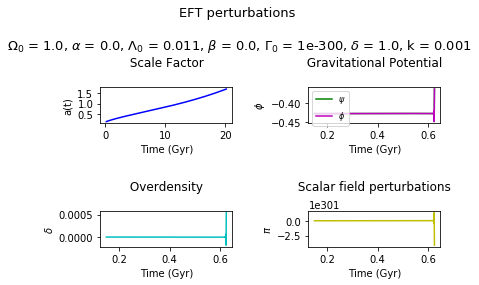

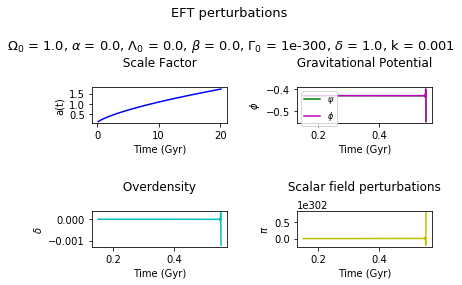

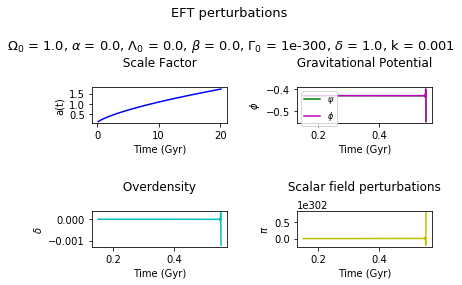

In [23]:
for i in range(len(models)):
        temp = models[i]
        Om, Ophi, name = temp[0], temp[1], temp[2]
        OM0, Lambda0, Gamma0= 1., -1*math.pow(H0, 2)*Ophi*3, 1E-300
        Eft = EFT(Om, Ophi, H0, a0, t0, it, dt)
        data = Eft.BackgroundTheory()[0]

        chi4 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, name)
        chi4.plotting([0., OM0, 0., Lambda0, 1., Gamma0])

## Minimize the Background Energy

Success for  Concordance model ?:  True  Parameters:  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.11886622e-02
  0.00000000e+00  1.00000000e-05]
Chi-Squared:  0.0005599733768262324


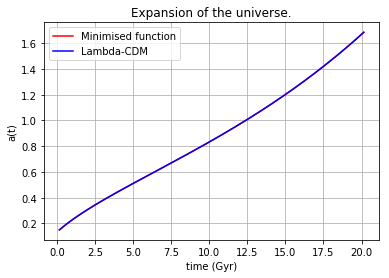

Success for  Einstein de Sitter model ?:  True  Parameters:  [ 0.e+00  1.e+00  0.e+00 -0.e+00  0.e+00  1.e-05]
Chi-Squared:  0.0007669841454383379


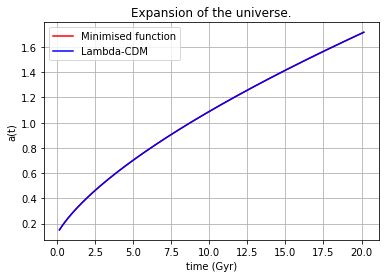

Success for  Einstein de Sitter model ?:  True  Parameters:  [ 0.e+00  1.e+00  0.e+00 -0.e+00  0.e+00  1.e-05]
Chi-Squared:  0.0007669841454383379


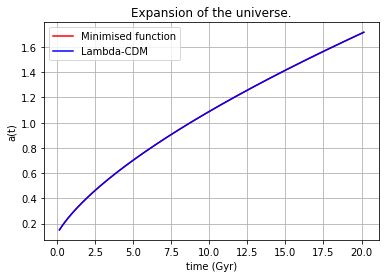

In [24]:
for i in range(len(models)):
        if chirun == 1.:
            temp = models[i]
            Om, Ophi, name = temp[0], temp[1], temp[2]
            OM0, Lambda0, Gamma0, beta = 1., -1*math.pow(H0, 2)*Ophi*3, 1E-5, 0.
            Eft = EFT(Om, Ophi, H0, a0, t0, it, dt)
            data = Eft.BackgroundTheory()[0]
            chi4 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, name)
            value = minimize(chi4, [0., OM0, 0., Lambda0, 0., Gamma0])
            print('Success for ', name, 'model ?: ', value.success, ' Parameters: ', value.x)
            print('Chi-Squared: ', value.fun)
            new = chi4.function(value.x)

            # Plotting the function
            plt.plot(t, new[0][0:len(t)], 'r', label = 'Minimised function')
            plt.plot(t, data, 'b', label = 'Lambda-CDM')
            plt.legend(loc = 2)
            plt.title('Expansion of the universe.')
            plt.ylabel('a(t)')
            plt.xlabel('time (Gyr)')
            plt.grid(True)
            plt.show()